# Goal
- try out more hidden layers (instead of 3 try 4-8 until can use 512 dense network and have $10^6$ params)

In [0]:
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
%cd /content/drive/My\ Drive/ece1512/project/ece1512_project
from deep_consensus import deep_consensus_wrapper
import fit_generator_helper, customizable_deep_network
import mrc

/content/drive/My Drive/ece1512/project/ece1512_project


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


# set up data
- J109 ligand
- J110 no ligand
- J119 missing quarter core
- J123 missing half core
- J125 missing particle
- J128 full particle (missing tiny piece of noise)
- J138 missing small region, size 4
- J139 missing small region, size 2
- J145 sc all
- J146 sc small region missing, bit smaller than cytc, hard to see in 2d class
- J151 sc 2x cytc missing

In [0]:
fname_list = []
label_list=[]
# each directory is associated with a label. there are multiple mrcs files in the directory (only two for now, but probably tens later with more data)
for fname in glob.glob('/content/drive/My Drive/ece1512/project/P11/J145/*.mrcs'):#[:-1]:
  label_list.append(0)
  fname_list.append(fname)

for fname in glob.glob('/content/drive/My Drive/ece1512/project/P11/J151/*.mrcs'):#[-1:]:
  label_list.append(1)
  fname_list.append(fname) 
                      

df = fit_generator_helper.parse_files(fname_list,label_list)
df = df.sample(df.shape[0])
header = mrc.read_header(fname_list[0])
nx,ny=header['nx'],header['nx']
val_n = int(0.1*df.shape[0]) # 10%/90% test/train split
df = df.iloc[:-val_n]
df_val = df.iloc[-val_n:]

In [5]:
X_val,Y_val = fit_generator_helper.XY_from_df_batch(df_val,nx=nx,ny=ny) # crop 
X_val.shape

(200, 380, 380, 1)

In [0]:
from scipy.ndimage.filters import gaussian_filter

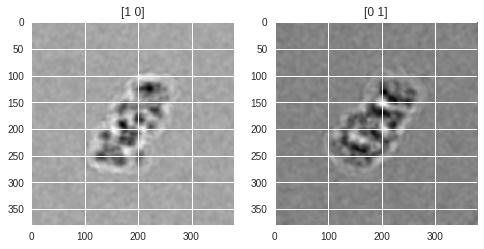

In [18]:
X,Y = X_val,Y_val

# first index of different labels (shuffled up)
s,e=0,10
i=np.argwhere((Y_val[s:e]==np.array([1,0])).mean(1) == 1).flatten()[0]
j=np.argwhere((Y_val[s:e]==np.array([0,1])).mean(1) == 1).flatten()[0]

sigma=3

fig = plt.figure()
a = fig.add_subplot(121)
a.set_title('%s' % Y[i]) # class 1
plt.imshow(gaussian_filter(X[i,:,:,0],sigma),cmap='gray')

a = fig.add_subplot(122)
a.set_title('%s' % Y[j]) # class 0
plt.imshow(gaussian_filter(X[j,:,:,0],sigma),cmap='gray')


# build model

### `deep_consensus_wrapper`

In [0]:
from keras.optimizers import Adam, SGD


In [20]:
model = deep_consensus_wrapper(input_shape=X.shape[1::],dense13_n=512,optimizer=SGD())
print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 380, 380, 8)       1808      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 380, 380, 8)       14408     
_________________________________________________________________
batch_normalization_1 (Batch (None, 380, 380, 8)       32        
_________________________________________________________________
activation_1 (Activation)    (None, 380, 380, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 190, 190, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 190, 190, 8)       3144      
___________________________

### `customizable_deep_network`

In [0]:
def architecture_params_wrapper(blocks=5,
                                inputl_kernel=15,
                                inputl_node=8,
                                hiddenl_kernels=(7,5),
                                hiddenl_nodes=((8,16),(32,32)),
                                pooling_sizes = (7,5,3),
                                n1_ave_pool=64, 
                                n2_ave_pool=64, 
                                k1_ave_pool=3, 
                                k2_ave_pool=3, 
                                av_pool=4,
                                val_dense=512,
                                drop=0.5
                               ):
  params={}
  params['blocks'] = blocks # Each block has 5 layers = 2 Conv2D + 1 Activation + 1 Normalization + 1 Pooling


  """ 
  Helper function to make architecture inspired by deep consensus
  param blocks: Each block has 5 layers = 2 Conv2D + 1 Activation + 1 Normalization + 1 Pooling
  param k1_size:  Kernel size of the first Conv2D layer
  param K2_size: Kernel size of the second Conv2D layer
  param pool1: max pooling size
  returns: param dictionary
  """

  #inputl_kernel = [k1_size,k2_size]
  """Represents the kernel size of the first layer of the network or call input layer"""
  assert type(inputl_kernel) == int
  params['inputl_kernel'] = [inputl_kernel,inputl_kernel]

  #inputl_node =  [node1_number, node2_number]
  """Represents the number of node that each CONV2D layer has in the first layer"""
  assert type(inputl_node) == int
  params['inputl_node'] = [inputl_node,inputl_node]

  #hiddenl_kernel = [k3_size, k4_size, k5_size,k6_size,...] # Depends on the number of layers
  """Represents the kernel size of the hidden layers of the network"""
  
  params['hiddenl_kernel']=[]
  assert len(hiddenl_kernels) == blocks - 3
  for i in hiddenl_kernels:
    assert type(i) == int                         
    params['hiddenl_kernel'].extend((i,i)) # [11, 11,7, 7,5,5,3,3]

  # hiddenl_node = [node3_number, node4_number, node5_number, node6_number,...] # Depends on the number of layers
  """Represents the number of node that each CONV2D layer has in the hidden layers"""
  params['hiddenl_node']=[]
  assert len(hiddenl_nodes) == blocks - 3
  for i in hiddenl_nodes:
    assert type(i) == tuple
    assert len(i) == 2                         
    params['hiddenl_node'].extend(i) # [8,16,32,32,32,32,32,32]
  for i in params['hiddenl_node']:
    assert type(i) == int

  # pooling_size = [pool1_size, pool2_size, pool3_size, ...] # Depends on the number of layers
  """Represents the size of pooling layer in the input and hidden layer"""
  assert len(pooling_sizes) == blocks - 3 + 1
  params['pooling_size']=pooling_sizes

  # Penultimate Block
  # av_pool = [node1_number, node2_number, k1_size, k2_size, av_pool_size]
  #average_pool= [64, 64, 3, 3, 4]
  params['n1_ave_pool'] = n1_ave_pool
  params['n2_ave_pool'] = n2_ave_pool
  params['k1_ave_pool'] = k1_ave_pool
  params['k2_ave_pool'] = k2_ave_pool
  params['av_pool'] = av_pool

  # Output Layer = Full connected network
  params['val_dense'] = val_dense
  params['drop'] = drop
  return(params)

params = architecture_params_wrapper(blocks=6,
                                inputl_kernel=30,
                                inputl_node=8,
                                hiddenl_kernels=(15,7,5),
                                hiddenl_nodes=((8,8),(8,16),(32,32)),
                                pooling_sizes = (15,7,5,3),
                                n1_ave_pool=64, 
                                n2_ave_pool=64, 
                                k1_ave_pool=3, 
                                k2_ave_pool=3, 
                                av_pool=4,
                                val_dense=256,
                                drop=0.5
                               )

In [24]:
# Define input shape and number of classes

input_shape=X.shape[1::]
n_classes = 2

# Call function build_network

model = customizable_deep_network.build_network (
  blocks=params['blocks'],
  input_shape=input_shape, 
  inputl_node=params['inputl_node'],
  inputl_kernel=params['inputl_kernel'],
  hiddenl_node=params['hiddenl_node'],
    
  hiddenl_kernel=params['hiddenl_kernel'], 
  pooling_size=params['pooling_size'], 
  n1_ave_pool=params['n1_ave_pool'], 
  n2_ave_pool=params['n2_ave_pool'], 
    
  k1_ave_pool=params['k1_ave_pool'], 
  k2_ave_pool=params['k2_ave_pool'], 
  av_pool=params['av_pool'], 
  val_dense=params['val_dense'], 
  drop=params['drop'], 
  n_classes=n_classes)

print(model.summary())
model.compile(optimizer = SGD() , loss='categorical_crossentropy', metrics=['categorical_accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 380, 380, 8)       7208      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 380, 380, 8)       57608     
_________________________________________________________________
batch_normalization_10 (Batc (None, 380, 380, 8)       32        
_________________________________________________________________
activation_10 (Activation)   (None, 380, 380, 8)       0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 190, 190, 8)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 190, 190, 8)       14408     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 190, 190, 8)       14408     
__________

# train model

In [0]:
batch_size = 100
steps_per_epoch = np.floor(df.shape[0] / batch_size) # 110 for 11k particles

In [0]:
#model = loaded_model

In [26]:
for _ in range(5):
    print('epoch %i' % _)
    model.fit_generator(fit_generator_helper.image_loader(df,batch_size=batch_size,nx=nx,ny=ny),
                    steps_per_epoch=steps_per_epoch, # steps_per_epoch is number of batches per epoch
                    epochs=1,
                   )
    scores = model.evaluate(X_val, Y_val)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

epoch 0
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
200/200 [==============================] - 32s 158ms/step
categorical_accuracy: 73.00%
epoch 1
Epoch 1/1
200/200 [==============================] - 13s 67ms/step
categorical_accuracy: 100.00%
epoch 2
Epoch 1/1
200/200 [==============================] - 13s 67ms/step
categorical_accuracy: 100.00%
epoch 3
Epoch 1/1
200/200 [==============================] - 13s 67ms/step
categorical_accuracy: 100.00%
epoch 4
Epoch 1/1
200/200 [==============================] - 13s 67ms/step
categorical_accuracy: 100.00%


# Save model

In [0]:
import time
timestr = time.strftime('%Y%m%d-%H%M')


model_yaml = model.to_yaml()
with open('model-missing-2cytc-J145-J151-256dense-5epochs-'+timestr+'.yaml', "w") as yaml_file:
    yaml_file.write(model_yaml)
model.save_weights("model"+timestr+".h5")

In [0]:
timestr = '20190328-0241'

In [10]:
from keras.models import model_from_yaml


# load YAML and create model
yaml_file = open('model'+timestr+'.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model"+timestr+".h5")
loaded_model.compile(optimizer = SGD() , loss='categorical_crossentropy', metrics=['categorical_accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
scores = loaded_model.evaluate(X_val, Y_val)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], scores[1] * 100))

200/200 [==============================] - 7s 36ms/step
categorical_accuracy: 62.50%


# tune dense layer

In [0]:
for dense13_n in []:
    print('%i dense layer'% dense13_n)
    model_dense13_n = deep_consensus_wrapper(input_shape=X.shape[1::],dense13_n=dense13_n,optimizer=Adam())
    print(model_dense13_n.summary())
    for _ in range(40):
        print('epoch %i' % _)
        model_dense13_n.fit_generator(fit_generator_helper.image_loader(df,batch_size=batch_size,nx=nx,ny=ny,crop_n=400),
                        steps_per_epoch=steps_per_epoch, # steps_per_epoch is number of batches per epoch
                        epochs=1,
                        #use_multiprocessing=True,
                        #workers=5
                       )
        scores = model_dense13_n.evaluate(X_val, Y_val)
        print("%s: %.2f%%" % (model_dense13_n.metrics_names[1], scores[1] * 100))
    
    